In [1]:
#default_exp opts

In [16]:
#export
from collections import defaultdict
from typing import Union

import torch
from torch.optim.optimizer import Optimizer, required
import itertools as it
import math
import torch
from torch.optim.lr_scheduler import _LRScheduler, CosineAnnealingLR, ReduceLROnPlateau, StepLR

from collections import defaultdict
from itertools import chain
import warnings

warnings.filterwarnings('ignore')

In [3]:
#export
# Lookahead implementation from https://github.com/lonePatient/lookahead_pytorch/blob/master/optimizer.py
class Lookahead(Optimizer):
    '''
    PyTorch implementation of the lookahead wrapper.
    Lookahead Optimizer: https://arxiv.org/abs/1907.08610
    '''
    def __init__(self, optimizer, alpha=0.5, k=6, pullback_momentum="none"):
        '''
        :param optimizer:inner optimizer
        :param k (int): number of lookahead steps
        :param alpha(float): linear interpolation factor. 1.0 recovers the inner optimizer.
        :param pullback_momentum (str): change to inner optimizer momentum on interpolation update
        '''
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        self.optimizer = optimizer
        self.param_groups = self.optimizer.param_groups
        self.alpha = alpha
        self.k = k
        self.step_counter = 0
        assert pullback_momentum in ["reset", "pullback", "none"]
        self.pullback_momentum = pullback_momentum
        self.state = defaultdict(dict)

        # Cache the current optimizer parameters
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['cached_params'] = torch.zeros_like(p.data)
                param_state['cached_params'].copy_(p.data)

    def __getstate__(self):
        return {
            'state': self.state,
            'optimizer': self.optimizer,
            'alpha': self.alpha,
            'step_counter': self.step_counter,
            'k':self.k,
            'pullback_momentum': self.pullback_momentum
        }

    def zero_grad(self):
        self.optimizer.zero_grad()

    def state_dict(self):
        return self.optimizer.state_dict()

    def load_state_dict(self, state_dict):
        self.optimizer.load_state_dict(state_dict)

    def _backup_and_load_cache(self):
        """Useful for performing evaluation on the slow weights (which typically generalize better)
        """
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['backup_params'] = torch.zeros_like(p.data)
                param_state['backup_params'].copy_(p.data)
                p.data.copy_(param_state['cached_params'])

    def _clear_and_load_backup(self):
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                p.data.copy_(param_state['backup_params'])
                del param_state['backup_params']

    def step(self, closure=None):
        """Performs a single Lookahead optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = self.optimizer.step(closure)
        self.step_counter += 1

        if self.step_counter >= self.k:
            self.step_counter = 0
            # Lookahead and cache the current optimizer parameters
            for group in self.optimizer.param_groups:
                for p in group['params']:
                    param_state = self.state[p]
                    p.data.mul_(self.alpha).add_(1.0 - self.alpha, param_state['cached_params'])  # crucial line
                    param_state['cached_params'].copy_(p.data)
                    if self.pullback_momentum == "pullback":
                        internal_momentum = self.optimizer.state[p]["momentum_buffer"]
                        self.optimizer.state[p]["momentum_buffer"] = internal_momentum.mul_(self.alpha).add_(
                            1.0 - self.alpha, param_state["cached_mom"])
                        param_state["cached_mom"] = self.optimizer.state[p]["momentum_buffer"]
                    elif self.pullback_momentum == "reset":
                        self.optimizer.state[p]["momentum_buffer"] = torch.zeros_like(p.data)

        return loss

In [4]:
#export
class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value = 1 - beta2)
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(exp_avg, denom, value=-step_size * group['lr'])
                else:
                    p_data_fp32.add_(exp_avg, alpha=-step_size * group['lr'])

                p.data.copy_(p_data_fp32)

        return loss

In [5]:
#export
#from - https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer/blob/master/ranger/ranger.py
class Ranger(Optimizer):
    def __init__(self, params, lr=1e-3, alpha=0.5, k=6, N_sma_threshhold=5,
                 betas=(.95, 0.999), eps=1e-5, weight_decay=0,
                 use_gc=True, gc_conv_only=False):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr, alpha=alpha, k=k, step_counter=0, betas=betas,
                        N_sma_threshhold=N_sma_threshhold, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.use_gc = use_gc

        # level of gradient centralization
        self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}")
        if (self.use_gc and self.gc_gradient_threshold == 1):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_gradient_threshold == 3):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        
        if closure is not None:
            loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(state) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                if grad.dim() > self.gc_gradient_threshold:
                    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                # compute mean moving avg
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (
                            N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay']
                                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size *
                                         group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(self.alpha, p.data - slow_p)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)
        return loss

In [6]:
#export
class FlatCos(_LRScheduler):
    def __init__(self, 
                 optimizer:Optimizer, 
                 num_epochs:int, 
                 steps_per_epoch:int, 
                 pct_start: float=0.7, 
                 eta_min: float =0, 
                 last_epoch:int =-1):
        
        max_iter = num_epochs * steps_per_epoch
        self.flat_range = int(max_iter * pct_start)
        self.T_max = max_iter - self.flat_range
        self.eta_min = eta_min
        super(FlatCos, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.flat_range:
            return [base_lr for base_lr in self.base_lrs]
        else:
            cr_epoch = self.last_epoch - self.flat_range
            lrs = [self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * (cr_epoch / self.T_max)))/ 2 
                   for base_lr in self.base_lrs]
            return lrs

In [7]:
from src.core import *
from src.layers import *
from src.networks import *
from src.lightning.core import *
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [8]:
train_augs = A.Compose([
    A.RandomResizedCrop(224, 224, p=1.0),
    A.RandomBrightness(limit=0.1),
    A.HueSaturationValue(20, 20, 20),
    A.HorizontalFlip(),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)])

valid_augs = A.Compose([
    A.Resize(224, 224, p=1.0),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)])

csv = "../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv"
ims = "../../Datasets/cassava/train_images/"
dm = CassavaLightningDataModule(csv, ims, curr_fold=0, train_augs=train_augs, valid_augs=valid_augs, 
                                bs=32, num_workers=0)

dm.prepare_data()
dm.setup()
train_dl,valid_dl,test_dl = dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader()
train_dl, _ = torch.utils.data.random_split(train_dl.dataset, lengths=[100, len(train_dl.dataset) - 100])

example_conf = dict(
    mixmethod = None,
    loss_function = dict(_target_='src.core.LabelSmoothingCrossEntropy', eps=0.1),
    learning_rate = 1e-03,
    lr_mult = 100,
    optimizer = dict(_target_='src.opts.Ranger', betas=(0.9, 0.99), eps=1e-06, weight_decay=0),
    scheduler = dict(_target_='src.opts.FlatCos', num_epochs=10, pct_start=0.3),
    metric_to_track = None,
    step_after = "step",
    frequency = 1,
)

def train_dataloader(self): return torch.utils.data.DataLoader(train_dl)

LightningCassava.train_dataloader = train_dataloader

encoder = timm.create_model('resnet18', pretrained=False)
model = TransferLearningModel(encoder, cut=-2, c=5)
model = LightningCassava(model=model, conf=example_conf)

opt_list, lr_scheduler_list = model.configure_optimizers()
opt, lr_scheduler = opt_list[0], lr_scheduler_list[0]['scheduler']

DATA: ../../Datasets/cassava/train_images/
FOLD: 0  BATCH_SIZE: 32
Loss Function : LabelSmoothingCrossEntropy()
Optimizer: Ranger  LR's: (1e-05, 0.001)
LR Scheculer: FlatCos


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [9]:
lrs0 = []
lrs1 = []

for epoch in range(10):
    for idx in range(len(train_dl)):
        opt.step()
        lrs0.append(lr_scheduler.get_lr()[0])
        lrs1.append(lr_scheduler.get_lr()[1])
        lr_scheduler.step()

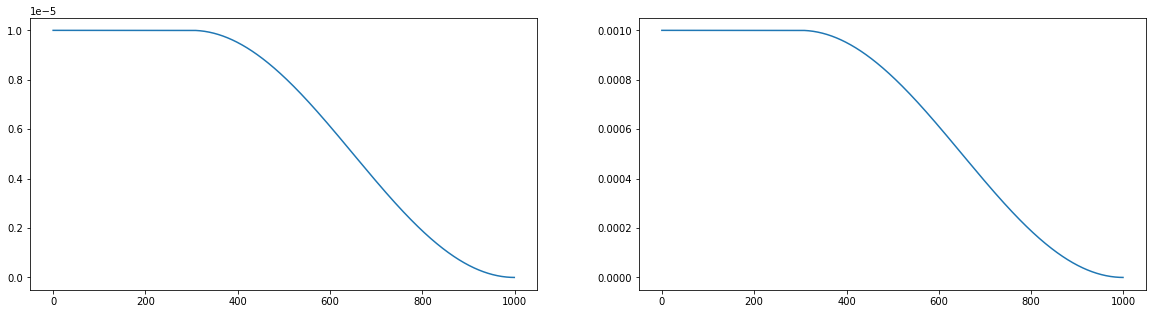

In [10]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 5))
ax0.plot(lrs0)
ax1.plot(lrs1)

In [11]:
rand_input = torch.randn((4, 255))
rand_model = torch.nn.Linear(in_features=255, out_features=1, bias=False)

rand_preds = rand_model(rand_input)
rand_output= torch.ones_like(rand_preds)
loss = torch.nn.functional.binary_cross_entropy_with_logits(rand_preds, rand_output)
loss.backward()

opt = Ranger(params(rand_model))
opt.step()

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [12]:
rand_input = torch.randn((4, 255))
rand_model = torch.nn.Linear(in_features=255, out_features=1, bias=False)

rand_preds = rand_model(rand_input)
rand_output= torch.ones_like(rand_preds)
loss = torch.nn.functional.binary_cross_entropy_with_logits(rand_preds, rand_output)
loss.backward()

opt = Ranger(params(rand_model))
opt.step()

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [13]:
#export
#from - https://github.com/ildoonet/pytorch-gradual-warmup-lr/blob/master/warmup_scheduler/scheduler.py
class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier if multiplier > 1.0. if multiplier = 1.0,
                    lr starts from 0 and ends up with the base_lr.
        total_epoch: target learning rate is reached at total_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """

    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier < 1.:
            raise ValueError('multiplier should be greater thant or equal to 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_last_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)

    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
                self._last_lr = self.after_scheduler.get_last_lr()
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


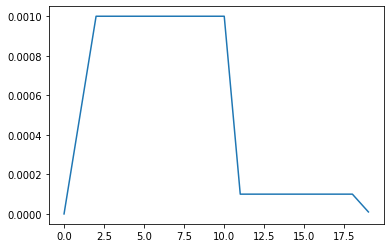

In [14]:
epoch = 20
rand_input = torch.randn((4, 255))
rand_model = torch.nn.Linear(in_features=255, out_features=1, bias=False)

rand_preds = rand_model(rand_input)
rand_output= torch.ones_like(rand_preds)
loss = torch.nn.functional.binary_cross_entropy_with_logits(rand_preds, rand_output)
loss.backward()

opt = Ranger(params(rand_model))
after_sch = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[8,16], gamma=0.1)
sch = GradualWarmupScheduler(opt, multiplier=1, total_epoch=2, after_scheduler=after_sch)

lr = []

for e in range(epoch):
    for idx in range(10):
        opt.step()
    lr.append(sch.get_lr())
    sch.step()

plt.plot(lr)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


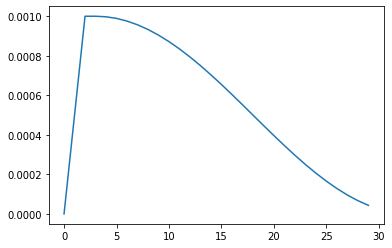

In [15]:
epoch = 30
rand_input = torch.randn((4, 255))
rand_model = torch.nn.Linear(in_features=255, out_features=1, bias=False)

rand_preds = rand_model(rand_input)
rand_output= torch.ones_like(rand_preds)
loss = torch.nn.functional.binary_cross_entropy_with_logits(rand_preds, rand_output)
loss.backward()

opt = Ranger(params(rand_model))
after_sch = CosineAnnealingLR(opt, T_max=epoch, eta_min=0)
sch = GradualWarmupScheduler(opt, multiplier=1, total_epoch=2, after_scheduler=after_sch)

lr = []

for e in range(epoch):
    for idx in range(10):
        opt.step()
    lr.append(sch.get_lr())
    sch.step()

plt.plot(lr)

In [25]:
#export
def CosineAnnealingWarmupScheduler(optimizer:Optimizer, total_epochs:int, 
                                   steps_per_epoch:int, eta_min:float=0., 
                                   pct_start:Union[float, int] = 0.1):
    
    "Warmup till `pct_start` after which CosineAnnealing"
    total_steps  = total_epochs * steps_per_epoch
    
    if isinstance(pct_start, int)    :  warmup_steps = pct_start
    elif isinstance(pct_start, float):  warmup_steps = pct_start * total_steps
    
    cosine_scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=eta_min)
    
    warmup_scheduler = GradualWarmupScheduler(optimizer, 
                                            multiplier=1, 
                                            total_epoch=warmup_steps, 
                                            after_scheduler=cosine_scheduler)
    return warmup_scheduler

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


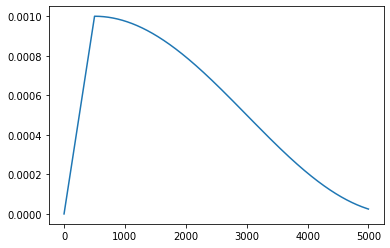

In [33]:
rand_input = torch.randn((4, 255))
rand_model = torch.nn.Linear(in_features=255, out_features=1, bias=False)

rand_preds = rand_model(rand_input)
rand_output= torch.ones_like(rand_preds)
loss = torch.nn.functional.binary_cross_entropy_with_logits(rand_preds, rand_output)
loss.backward()

total_epochs = 50
steps_per_epoch = 100

opt = Ranger(params(rand_model))
sch = CosineAnnealingWarmupScheduler(opt, total_epochs, steps_per_epoch, pct_start=0.1)

lr = []

for e in range(total_epochs):
    for idx in range(steps_per_epoch):
        opt.step()
        lr.append(opt.param_groups[0]['lr'])
        sch.step()

plt.plot(lr)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


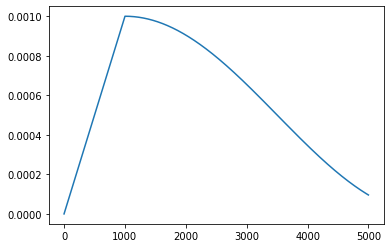

In [34]:
rand_input = torch.randn((4, 255))
rand_model = torch.nn.Linear(in_features=255, out_features=1, bias=False)

rand_preds = rand_model(rand_input)
rand_output= torch.ones_like(rand_preds)
loss = torch.nn.functional.binary_cross_entropy_with_logits(rand_preds, rand_output)
loss.backward()

total_epochs = 50
steps_per_epoch = 100

opt = Ranger(params(rand_model))
sch = CosineAnnealingWarmupScheduler(opt, total_epochs, steps_per_epoch, pct_start=1000)

lr = []

for e in range(total_epochs):
    for idx in range(steps_per_epoch):
        opt.step()
        lr.append(opt.param_groups[0]['lr'])
        sch.step()

plt.plot(lr)

In [36]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 00a_lightning.core.ipynb.
Converted 00b_fastai.core.ipynb.
Converted 01_mixmethods.ipynb.
Converted 01b_lightning.callbacks.ipynb.
Converted 02_layers.ipynb.
Converted 02a_networks.ipynb.
Converted 03_optimizers.ipynb.
Converted index.ipynb.
